**MACHINE LEARNING PROJECT**

Emma Roveroni 2058618

Marco Tesser 2058223

Data retrieval

In [ ]:
import numpy as np
from urllib.request import urlopen
import matplotlib.pyplot as plt

def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train), 784)
                                                                                            
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_fashion_mnist()

Preprocessing

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import math

scaler = MinMaxScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)
X = np.vstack((X_tr_scaled,X_te_scaled))
pca = PCA(0.95)
X_pca = pca.fit_transform(X)
X_train_pca = X_pca[:60000]
X_test_pca = X_pca[60000:]

Logistic Regression

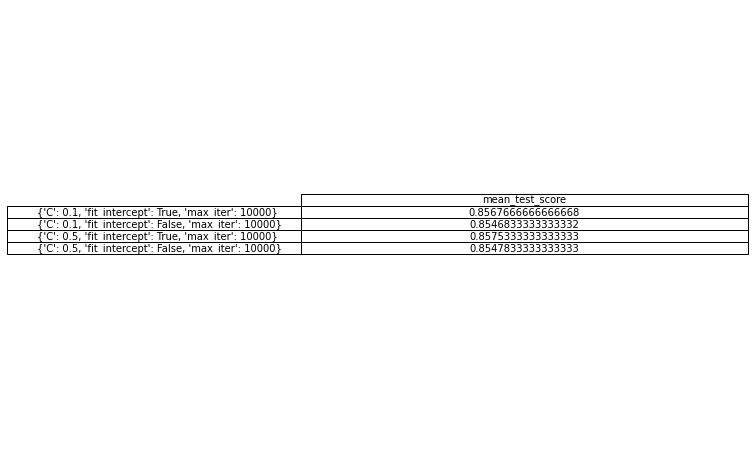

Best parameter configuration for Logistic Regression is: {'C': 0.5, 'fit_intercept': True, 'max_iter': 10000}
Test accuracy score with best parameters is : 0.8438


In [ ]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
param_grid = {
    'C': [0.1, 0.5],
    'fit_intercept': [True, False],
    'max_iter' : [10000]
}
grid_lr = GridSearchCV(model_lr, param_grid=param_grid, scoring = "accuracy")
grid_lr.fit(X_train_pca, Y_train)
#######
means = grid_lr.cv_results_['mean_test_score']
params = grid_lr.cv_results_['params']
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8,8)
data = np.array(means)
data = data.reshape((data.size,1))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, rowLabels=params,colLabels=["mean_test_score"] ,cellLoc = "center",loc='center')
plt.show()
#######
Y_pred = grid_lr.predict(X_test_pca)
print(f"Best parameter configuration for Logistic Regression is: {grid_lr.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(Y_test, Y_pred)}")

KNN

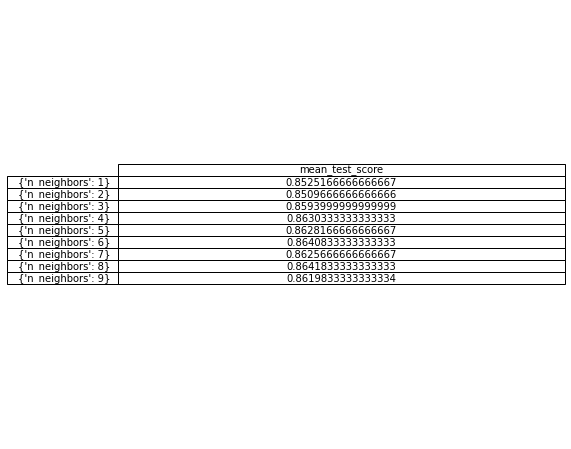

Best parameter configuration for K-NN is: {'n_neighbors': 8}
Test accuracy score with best parameters is : 0.8627


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
param_grid = dict(n_neighbors=list(range(1, 10)))
grid_knn = GridSearchCV(knn_model, param_grid, scoring = "accuracy")
grid_knn.fit(X_train_pca, Y_train)
#######
means = grid_knn.cv_results_['mean_test_score']
params = grid_knn.cv_results_['params']
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8,8)
data = np.array(means)
data = data.reshape((data.size,1))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, rowLabels=params,colLabels=["mean_test_score"] ,cellLoc = "center",loc='center')
plt.show()
#######
Y_pred = grid_knn.predict(X_test_pca)
print(f"Best parameter configuration for K-NN is: {grid_knn.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(Y_test, Y_pred)}")

Neural Network

The best parameter configuation for Neural Network is: 4 (hidden) layers,150 neurons and batch size = 8
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 150)               28350     
                                                                 
 dense_63 (Dense)            (None, 107)               16157     
                                                                 
 dense_64 (Dense)            (None, 64)                6912      
                                                                 
 dense_65 (Dense)            (None, 21)                1365      
                                                                 
 dense_66 (Dense)            (None, 10)                220       
                                                                 
Total params: 53,004
Trainable params: 53,004
Non-trainable params: 0
___________

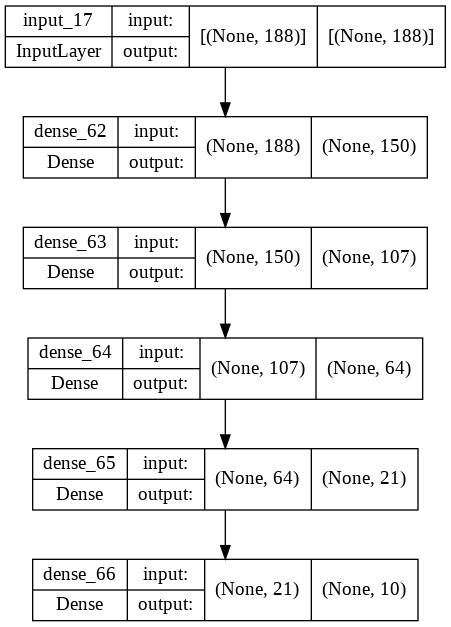

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

labels = set(Y_train)

features = X_train_pca.shape[1]
num_classes = len(labels)

y_train_cat = to_categorical(Y_train, num_classes)
y_test_cat = to_categorical(Y_test, num_classes)

def NN_Builder(n_layers, neurons):
    
    np.random.seed(123)
    set_random_seed(2)

    decreasing_index = math.floor((neurons-20)/(n_layers-1))
    model = Sequential()
    model.add(Input(features))

    for index, i in enumerate(range(n_layers)):
      
      model.add(Dense(units = neurons-decreasing_index*index, activation = 'relu'))

    model.add(Dense(units = num_classes, activation= 'softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='sgd', 
              metrics=['accuracy'])

    return model


es = EarlyStopping(monitor='val_accuracy', 
                   mode='max',  
                   patience = 3,
                   min_delta=0.01,
                   )


layers = [2,4,6]
neurons = [50,100,150]
batch_sizes = [16,8,4]
result = {}
models = {}
histories = {}

for l in layers:
  for n in neurons:
    for b in batch_sizes:
      model = NN_Builder(l,n)
      history = model.fit(X_train_pca, y_train_cat, epochs=500, batch_size=b, verbose=0, validation_split = 0.2, callbacks=[es])
      models[f"{l} (hidden) layers,{n} neurons in the first layer and batch size = {b}"] = model
      histories[f"{l} (hidden) layers,{n} neurons in the first layer and batch size = {b}"] = history
      result[f"{l} (hidden) layers,{n} neurons in the first layer and batch size = {b}"] = history.history['val_accuracy'][-1]
result = list(result.items())     
result.sort(key = lambda item:item[1],reverse = True)
bestresult = result[0][0]
print(f"The best parameter configuation for Neural Network is: {bestresult}")
models[bestresult].summary()
plot_model(models[bestresult], show_shapes= True)

Test accuracy score with best parameters is : 0.8725000023841858


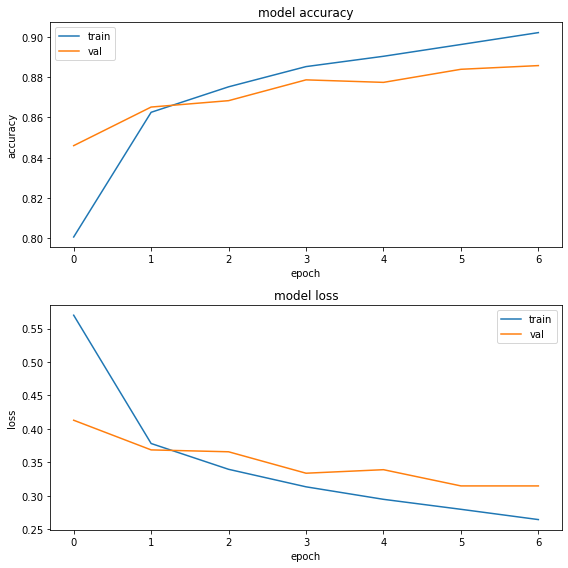

In [ ]:
test_results = models[bestresult].evaluate(X_test_pca, y_test_cat, verbose=0)
print(f"Test accuracy score with best parameters is : {test_results[1]}")
#####
fig,(ax1, ax2)= plt.subplots(2,1)
fig.set_size_inches(8,8)
ax1.plot(histories[bestresult].history['accuracy']) 
ax1.plot(histories[bestresult].history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'])
ax2.plot(histories[bestresult].history['loss'])
ax2.plot(histories[bestresult].history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'])
plt.tight_layout()
plt.show()

Decision Tree

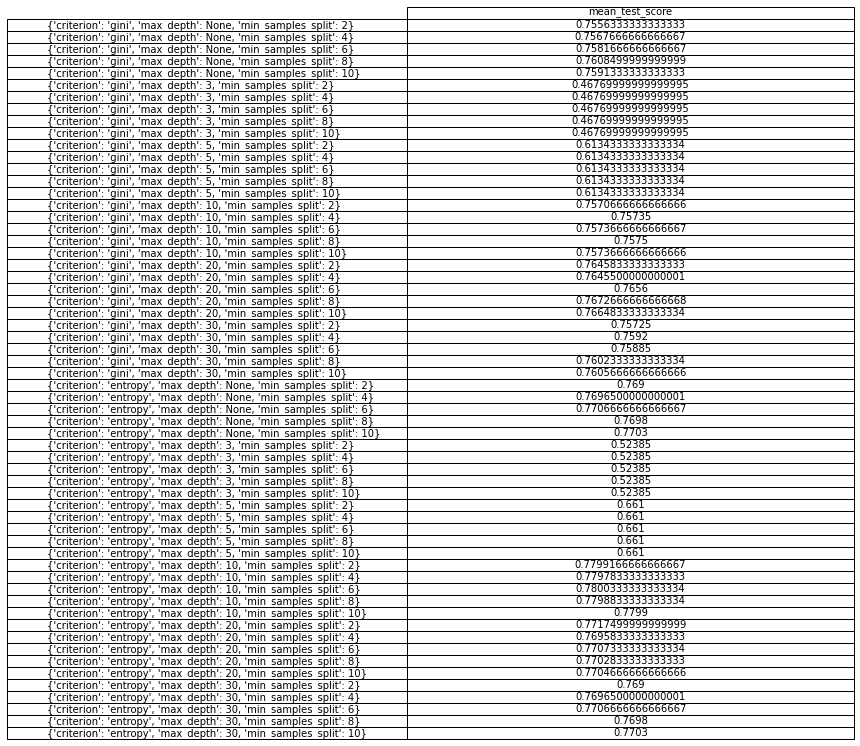

Best parameter configuration for Decision Tree is: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 6}
Test accuracy score with best parameters is : 0.7796


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state= 123)
grid_params = {
    'max_depth' : [None,3,5,10,20,30],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2,4,6,8,10]
}
grid_dt = GridSearchCV(dt_model, grid_params, scoring = "accuracy")
grid_dt.fit(X_train_pca, Y_train)
#######
means = grid_dt.cv_results_['mean_test_score']
params = grid_dt.cv_results_['params']
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8,8)
data = np.array(means)
data = data.reshape((data.size,1))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, rowLabels=params,colLabels=["mean_test_score"] ,cellLoc = "center",loc='center')
plt.show()
#######
Y_pred = grid_dt.predict(X_test_pca)
print(f"Best parameter configuration for Decision Tree is: {grid_dt.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(Y_test, Y_pred)}")

Random Forest

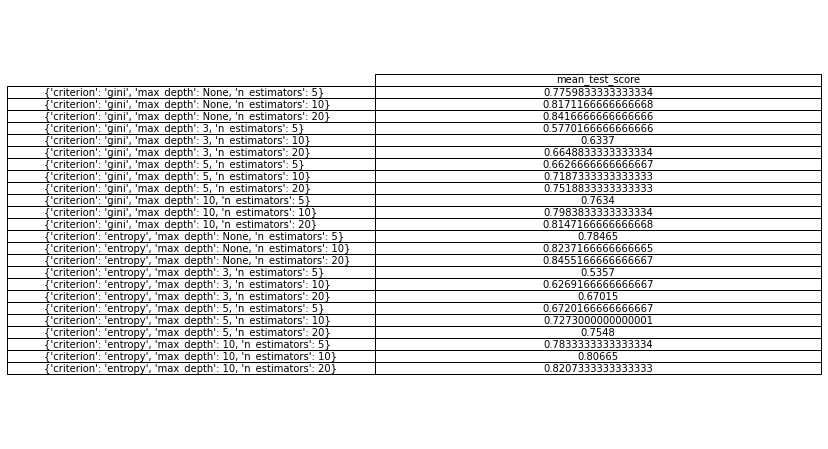

Best parameter configuration for Random Forest is: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 20}
Test accuracy score with best parameters is : 0.8392


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state= 123)
grid_params = {
    'n_estimators': [5, 10, 20],
    'criterion': ['gini','entropy'],
    'max_depth': [None,3, 5, 10]
}
grid_rf = GridSearchCV(rf_model, grid_params, scoring = "accuracy")
grid_rf.fit(X_train_pca, Y_train)
#######
means = grid_rf.cv_results_['mean_test_score']
params = grid_rf.cv_results_['params']
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8,8)
data = np.array(means)
data = data.reshape((data.size,1))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, rowLabels=params,colLabels=["mean_test_score"] ,cellLoc = "center",loc='center')
plt.show()
#######
Y_pred = grid_rf.predict(X_test_pca)
print(f"Best parameter configuration for Random Forest is: {grid_rf.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(Y_test, Y_pred)}")

SVM

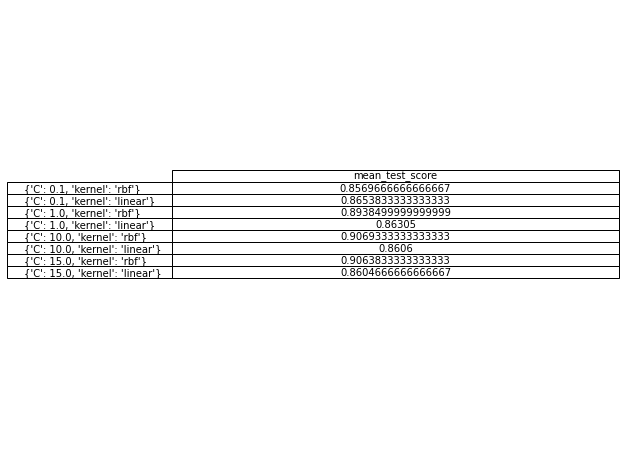

Best parameter configuration for SVC is: {'C': 10.0, 'kernel': 'rbf'}
Test accuracy score with best parameters is : 0.9006


In [ ]:
from sklearn.svm import SVC
svc_model = SVC(random_state= 123)
grid_params = {
    'C': [0.1, 1., 10., 15.],
    'kernel': ['rbf', 'linear']
}
grid_svc = GridSearchCV(svc_model, grid_params, scoring = "accuracy")
grid_svc.fit(X_train_pca, Y_train)
#######
means = grid_svc.cv_results_['mean_test_score']
params = grid_svc.cv_results_['params']
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8,8)
data = np.array(means)
data = data.reshape((data.size,1))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, rowLabels=params,colLabels=["mean_test_score"] ,cellLoc = "center",loc='center')
plt.show()
#######
Y_pred = grid_svc.predict(X_test_pca)
print(f"Best parameter configuration for SVC is: {grid_svc.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(Y_test, Y_pred)}")

Final results and confusion matrix

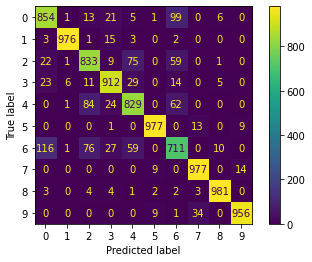

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, Y_pred, labels=grid_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_svc.classes_)
disp.plot()
plt.show()